<a href="https://colab.research.google.com/github/liamore14/Entrenamiento-distribuido-de-Redes-Neuronales-/blob/master/Entrenamiento_distribuido_mirroredstrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Entrenamiento distribuido de redes neuronales**

In [ ]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from psutil import *
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import np_utils
import tensorflow_datasets as tfds

##**Carga y Pre procesado del dataset**
---

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

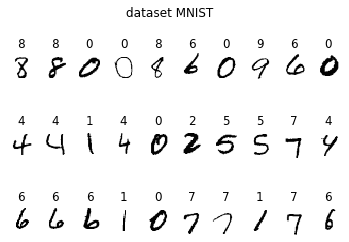

In [ ]:
ids_imgs = np.random.randint(0,x_train.shape[0],30)
for i in range(len(ids_imgs)):
	img = x_train[ids_imgs[i],:,:]
	plt.subplot(3,10,i+1)
	plt.imshow(img, cmap='Greys')
	plt.axis('off')
	plt.title(y_train[ids_imgs[i]])
plt.suptitle('dataset MNIST')
plt.show()

In [ ]:
X_train = np.reshape( x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2]) )
X_test = np.reshape( x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]) )

X_train = X_train/255.0
X_test = X_test/255.0

## **Modelo distribuido**
---

In [ ]:
distribute = tf.distribute.MirroredStrategy() #Definir una estrategia distribuida
with distribute.scope():
  modeldistributed = tf.keras.models.Sequential()
  modeldistributed.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(784,)))
  modeldistributed.add(tf.keras.layers.Dropout(rate=0.001))
  modeldistributed.add(tf.keras.layers.Dense(units=10, activation='softmax'))
  modeldistributed.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

## **Modelo no distribuido**
---

In [ ]:
modelnormal= tf.keras.models.Sequential()
modelnormal.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(784,)))
modelnormal.add(tf.keras.layers.Dropout(rate=0.001))
modelnormal.add(tf.keras.layers.Dense(units=10, activation='softmax'))
modelnormal.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

**Entrenar y comparar la velocidad de entrenamiento normal vs distribuida**

In [ ]:
start_time = time.time()
historynormal= modelnormal.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
print("El entrenamiento normal ha tardado: {}".format(time.time() - start_time))

El entrenamiento normal ha tardado: 28.520984649658203


In [ ]:
start_time = time.time()
historydistributed= modeldistributed.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
print("El entrenamiento distribuido ha tardado: {}".format(time.time() - start_time))

El entrenamiento distribuido ha tardado: 18.487309455871582


## **Validacion**
---

In [ ]:
def showresults(mod, hist):
  # Calcular la precisión sobre el set de validación
  puntaje = mod.evaluate(X_test,y_test,verbose=0)
  print('Precisión en el set de validación: {:.1f}%'.format(100*puntaje[1]))
  # Error y precisión vs iteraciones
  plt.subplot(1,2,1)
  plt.plot(hist.history['loss'])
  plt.title('Pérdida vs. iteraciones')
  plt.ylabel('Pérdida')
  plt.xlabel('Iteración')

  plt.subplot(1,2,2)
  plt.plot(hist.history['sparse_categorical_accuracy'])
  plt.title('Precisión vs. iteraciones')
  plt.ylabel('Precisión')
  plt.xlabel('Iteración')

  plt.show()

  Y_pred = mod.predict_classes(X_test)

  ids_imgs = np.random.randint(0,X_test.shape[0],9)
  for i in range(len(ids_imgs)):
    idx = ids_imgs[i]
    img = X_test[idx,:].reshape(28,28)
    cat_original = np.argmax(Y_test[idx,:])
    cat_prediccion = Y_pred[idx]

    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('predict "{}"'.format(cat_prediccion))
  plt.suptitle('Ejemplos de clasificación en el set de validación')
  plt.show()


Precisión en el set de validación: 97.8%


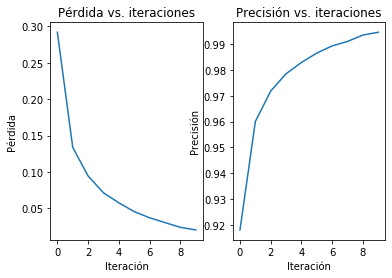

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


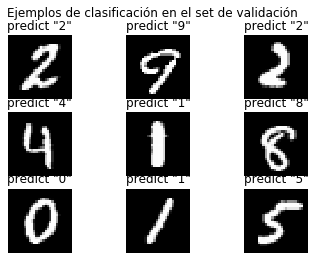

In [ ]:
showresults(modelnormal,historynormal) 

Precisión en el set de validación: 97.8%


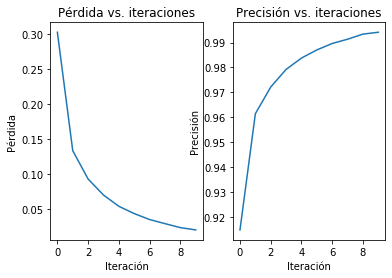

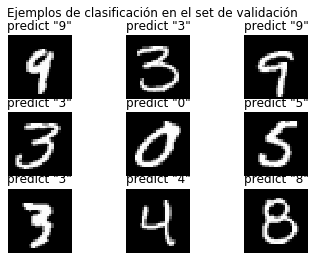

In [ ]:
showresults(modeldistributed,historydistributed) 

### **Hardware local**
---

In [ ]:
cpu_count()

8